In [97]:
import os
train_dir = "/kaggle/input/face-expression-recognition-dataset/images/train"
val_dir = "/kaggle/input/face-expression-recognition-dataset/images/validation"

print(os.listdir(train_dir))

['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']


In [98]:
from collections import Counter

# 1️⃣ Count images per class
def count_images(folder):
    class_counts = {}
    for cls in os.listdir(folder):
        cls_path = os.path.join(folder, cls)
        if os.path.isdir(cls_path):
            class_counts[cls] = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg','.png','.jpeg'))])
    return class_counts

print("📌 BEFORE REMOVING CLASSES:")
before_counts = count_images(train_dir)
for cls, count in before_counts.items():
    print(f"{cls}: {count}")

📌 BEFORE REMOVING CLASSES:
surprise: 3205
fear: 4103
angry: 3993
neutral: 4982
sad: 4938
disgust: 436
happy: 7164


In [99]:
import shutil

source_dir = "/kaggle/input/face-expression-recognition-dataset/images/train"
target_dir = "/kaggle/working/train_filtered"

keep_classes = ["angry", "happy", "neutral", "surprise"]

os.makedirs(target_dir, exist_ok=True)

for cls in keep_classes:
    src_path = os.path.join(source_dir, cls)
    dst_path = os.path.join(target_dir, cls)

    if os.path.exists(src_path):
        shutil.copytree(src_path, dst_path, dirs_exist_ok=True)
        print(f"✔ Copied class: {cls}")
    else:
        print(f"⚠ Class not found: {cls}")


FileExistsError: [Errno 17] File exists: '/kaggle/working/train_filtered/angry'

In [100]:
train_dir = "/kaggle/working/train_filtered"
classes = ["angry", "neutral", "happy", "surprise"]

# 1️⃣ Count images per class
def count_images(folder):
    class_counts = {}
    for cls in os.listdir(folder):
        cls_path = os.path.join(folder, cls)
        if os.path.isdir(cls_path):
            class_counts[cls] = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg','.png','.jpeg'))])
    return class_counts

print("📌 BEFORE REMOVING CLASSES:")
before_counts = count_images(train_dir)
for cls, count in before_counts.items():
    print(f"{cls}: {count}")

📌 BEFORE REMOVING CLASSES:
angry: 3200
neutral: 3200
happy: 3200
surprise: 3200


In [101]:
TARGET_MIN = 3200   # minimum per class
TARGET_MAX = 3500   # maximum per class (optional, ekhane use korchi na)


def list_images_in_class(class_name):
    class_path = os.path.join(train_dir, class_name)
    exts = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
    if not os.path.exists(class_path):
        return []
    files = [
        f for f in os.listdir(class_path)
        if os.path.isfile(os.path.join(class_path, f)) and f.lower().endswith(exts)
    ]
    return files


def random_augment(img: Image.Image) -> Image.Image:
    # Simple augmentation: horizontal/vertical flip + small rotation
    if random.random() < 0.5:
        img = ImageOps.mirror(img)   # horizontal flip
    if random.random() < 0.3:
        img = ImageOps.flip(img)     # vertical flip
    angle = random.uniform(-15, 15)
    img = img.rotate(angle, expand=True)
    return img


def balance_class(class_name):
    class_path = os.path.join(train_dir, class_name)
    os.makedirs(class_path, exist_ok=True)

    files = list_images_in_class(class_name)
    current_count = len(files)

    print(f"Before augment -> {class_name}: {current_count}")

    # Jodi already >= TARGET_MIN, kono augmentation dorkar nai
    if current_count >= TARGET_MIN:
        print(f"{class_name} already has enough samples, skipping augmentation.")
        return current_count

    # Need to create (TARGET_MIN - current_count) new augmented images
    needed = TARGET_MIN - current_count

    if current_count == 0:
        print(f"Warning: {class_name} has 0 images, cannot augment.")
        return current_count

    for i in range(needed):
        src_name = random.choice(files)
        src_path = os.path.join(class_path, src_name)

        try:
            img = Image.open(src_path).convert("RGB")
        except Exception as e:
            print(f"Error opening {src_path}: {e}")
            continue

        aug_img = random_augment(img)

        base, ext = os.path.splitext(src_name)
        new_name = f"{base}_aug_{i}{ext}"
        new_path = os.path.join(class_path, new_name)

        # Ensure unique filename
        j = 0
        while os.path.exists(new_path):
            new_name = f"{base}_aug_{i}_{j}{ext}"
            new_path = os.path.join(class_path, new_name)
            j += 1

        aug_img.save(new_path)

    new_count = len(list_images_in_class(class_name))
    print(f"After augment  -> {class_name}: {new_count}")
    return new_count

In [102]:
print("Counts per class (after optional augmentation):")
before_counts = {}
for c in classes:
    before_counts[c] = balance_class(c)

print("\nFinal image counts:")
for c in classes:
    print(f"{c}: {before_counts[c]}")

Counts per class (after optional augmentation):
Before augment -> angry: 3200
angry already has enough samples, skipping augmentation.
Before augment -> neutral: 3200
neutral already has enough samples, skipping augmentation.
Before augment -> happy: 3200
happy already has enough samples, skipping augmentation.
Before augment -> surprise: 3200
surprise already has enough samples, skipping augmentation.

Final image counts:
angry: 3200
neutral: 3200
happy: 3200
surprise: 3200


In [103]:
TARGET_MIN = 3200   # final target per class

def list_images_in_class(class_name):
    class_path = os.path.join(train_dir, class_name)
    exts = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
    if not os.path.exists(class_path):
        return []
    files = [
        f for f in os.listdir(class_path)
        if os.path.isfile(os.path.join(class_path, f)) and f.lower().endswith(exts)
    ]
    return files

def trim_class_to_target(class_name, target=TARGET_MIN):
    class_path = os.path.join(train_dir, class_name)
    files = list_images_in_class(class_name)
    current_count = len(files)
    print(f"Before trim -> {class_name}: {current_count}")

    if current_count <= target:
        print(f"{class_name}: count <= target, no delete.")
        return current_count

    # Randomly keep `target` files, delete others
    keep_files = set(random.sample(files, target))
    delete_files = [f for f in files if f not in keep_files]

    for f in delete_files:
        file_path = os.path.join(class_path, f)
        try:
            os.remove(file_path)
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")

    new_files = list_images_in_class(class_name)
    new_count = len(new_files)
    print(f"After trim  -> {class_name}: {new_count}")
    return new_count

print("Trimming classes to 3200 images each...\n")

after_counts = {}
for c in classes:
    after_counts[c] = trim_class_to_target(c, TARGET_MIN)

print("\nFinal image counts (after delete):")
for c in classes:
    print(f"{c}: {after_counts[c]}")

Trimming classes to 3200 images each...

Before trim -> angry: 3200
angry: count <= target, no delete.
Before trim -> neutral: 3200
neutral: count <= target, no delete.
Before trim -> happy: 3200
happy: count <= target, no delete.
Before trim -> surprise: 3200
surprise: count <= target, no delete.

Final image counts (after delete):
angry: 3200
neutral: 3200
happy: 3200
surprise: 3200


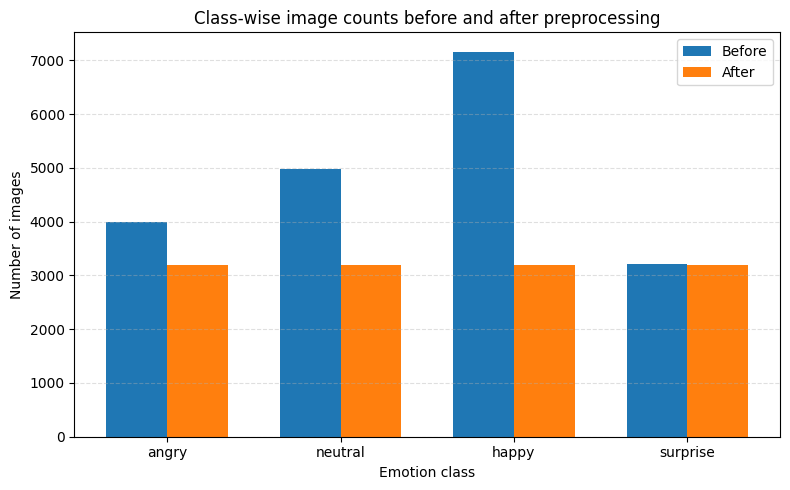

In [104]:
import numpy as np
import matplotlib.pyplot as plt

# classes list jeta upore use korcho
# classes = ["angry", "neutral", "happy", "surprise"]

# 1) Dict -> list (order same as `classes`)
before_vals = [3993, 4982, 7164, 3205]
after_vals  = [after_counts[c]  for c in classes]

# 2) Bar chart
x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, before_vals, width, label='Before')
plt.bar(x + width/2, after_vals,  width, label='After')

plt.xlabel("Emotion class")
plt.ylabel("Number of images")
plt.title("Class-wise image counts before and after preprocessing")
plt.xticks(x, classes)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [30]:
!pip show protobuf
!pip install protobuf==3.20.3
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Only show warnings and errors


Name: protobuf
Version: 6.33.0
Summary: 
Home-page: https://developers.google.com/protocol-buffers/
Author: protobuf@googlegroups.com
Author-email: protobuf@googlegroups.com
License: 3-Clause BSD License
Location: /usr/local/lib/python3.11/dist-packages
Requires: 
Required-by: a2a-sdk, google-ai-generativelanguage, google-api-core, google-cloud-aiplatform, google-cloud-appengine-logging, google-cloud-audit-log, google-cloud-bigquery-connection, google-cloud-bigtable, google-cloud-dataproc, google-cloud-datastore, google-cloud-discoveryengine, google-cloud-firestore, google-cloud-functions, google-cloud-iam, google-cloud-language, google-cloud-logging, google-cloud-monitoring, google-cloud-resource-manager, google-cloud-secret-manager, google-cloud-spanner, google-cloud-speech, google-cloud-trace, google-cloud-translate, google-cloud-videointelligence, google-cloud-vision, google-generativeai, googleapis-common-protos, grpc-google-iam-v1, grpcio-status, in-toto-attestation, kaggle, onnx

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from matplotlib.image import imread 


Class: angry | Total images: 3200 | Showing 5 images


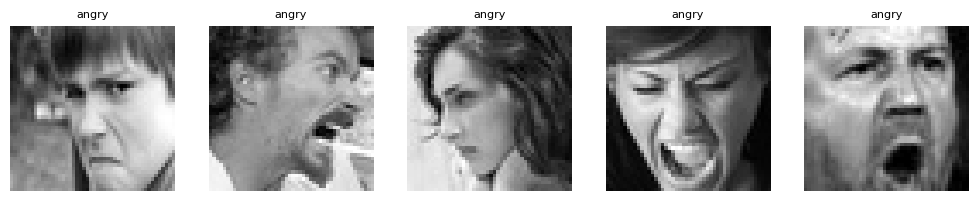


Class: happy | Total images: 3200 | Showing 5 images


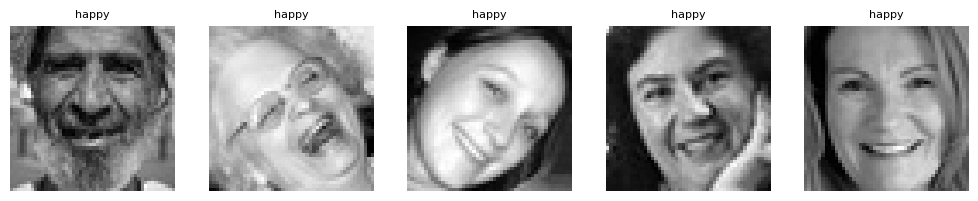


Class: neutral | Total images: 3200 | Showing 5 images


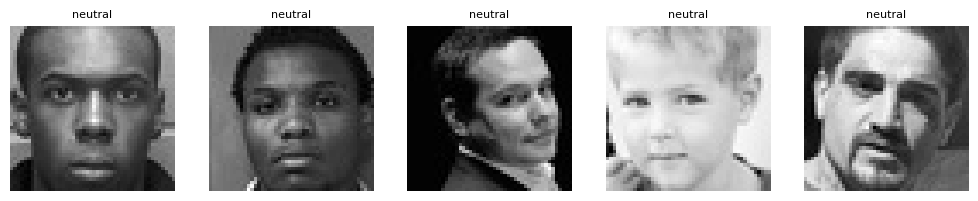


Class: surprise | Total images: 3200 | Showing 5 images


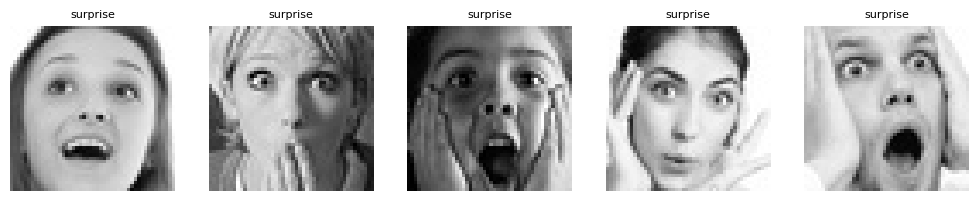

In [106]:
# =========================
# Loop through each class
# =========================
for class_name in sorted(os.listdir(train_dir)):
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    sample_imgs = random.sample(images, min(5, len(images)))  # max 5 images

    print(f"\nClass: {class_name} | Total images: {len(images)} | Showing {len(sample_imgs)} images")

    # Plot images in grid
    n_cols = 10
    n_rows = (len(sample_imgs) + n_cols - 1) // n_cols
    plt.figure(figsize=(20, 2*n_rows))

    for i, img_name in enumerate(sample_imgs):
        img_path = os.path.join(class_path, img_name)
        img = imread(img_path)

        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(class_name, fontsize=8)

    plt.tight_layout()
    plt.show()

In [107]:
import os
import shutil

source_dir = "/kaggle/input/face-expression-recognition-dataset/images/validation"
val_dir    = "/kaggle/working/val_filtered"   # ✅ alada validation folder

keep_classes = ["angry", "happy", "neutral", "surprise"]

os.makedirs(val_dir, exist_ok=True)

for cls in keep_classes:
    src_path = os.path.join(source_dir, cls)
    dst_path = os.path.join(val_dir, cls)

    if os.path.exists(src_path):
        # jodi ager theke thake, age remove kore new kore copy
        if os.path.exists(dst_path):
            shutil.rmtree(dst_path)
        shutil.copytree(src_path, dst_path)
        print(f"✔ Copied val class: {cls}")
    else:
        print(f"⚠ Class not found in val: {cls}")


✔ Copied val class: angry
✔ Copied val class: happy
✔ Copied val class: neutral
✔ Copied val class: surprise


In [108]:
import shutil

val_src_dir = "/kaggle/working/val_filtered"   # ekhon validation data ekhane ache
val_dir = "/kaggle/working/val"            # final validation
test_dir = "/kaggle/working/test"          # final test
classes = ["angry", "happy", "neutral", "surprise"]

split_ratio = 0.5   # 50% val, 50% test

# Output folders create
for d in [val_dir, test_dir]:
    os.makedirs(d, exist_ok=True)
    for cls in classes:
        os.makedirs(os.path.join(d, cls), exist_ok=True)

def list_images(folder):
    exts = (".jpg", ".jpeg", ".png")
    return [f for f in os.listdir(folder) if f.lower().endswith(exts)]

for cls in classes:
    src_class_dir = os.path.join(val_src_dir, cls)
    if not os.path.exists(src_class_dir):
        print(f"⚠ Class not found in val source: {cls}")
        continue

    files = list_images(src_class_dir)
    random.shuffle(files)

    n_total = len(files)
    n_val = int(n_total * split_ratio)
    val_files = files[:n_val]
    test_files = files[n_val:]

    # Copy to val
    for f in val_files:
        shutil.copy(
            os.path.join(src_class_dir, f),
            os.path.join(val_dir, cls, f)
        )

    # Copy to test
    for f in test_files:
        shutil.copy(
            os.path.join(src_class_dir, f),
            os.path.join(test_dir, cls, f)
        )

    print(f"{cls}: total={n_total}, val={len(val_files)}, test={len(test_files)}")


angry: total=960, val=480, test=480
happy: total=1825, val=912, test=913
neutral: total=1216, val=608, test=608
surprise: total=797, val=398, test=399


Train counts: {'angry': 3200, 'happy': 3200, 'neutral': 3200, 'surprise': 3200}
Val counts: {'angry': 713, 'happy': 1359, 'neutral': 896, 'surprise': 601}
Test counts: {'angry': 713, 'happy': 1360, 'neutral': 896, 'surprise': 602}


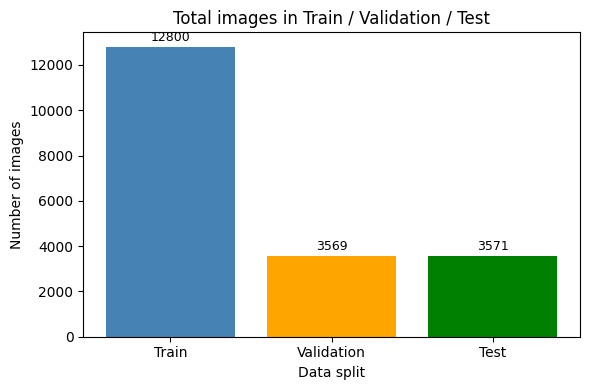

In [109]:
classes   = ["angry", "happy", "neutral", "surprise"]

def count_images_in_split(base_dir, classes):
    counts = {}
    for cls in classes:
        cls_path = os.path.join(base_dir, cls)
        if not os.path.exists(cls_path):
            counts[cls] = 0
            continue
        exts = (".jpg", ".jpeg", ".png")
        files = [
            f for f in os.listdir(cls_path)
            if f.lower().endswith(exts)
        ]
        counts[cls] = len(files)
    return counts

# Count per split
train_counts = count_images_in_split(train_dir, classes)
val_counts   = count_images_in_split(val_dir, classes)
test_counts  = count_images_in_split(test_dir, classes)

print("Train counts:", train_counts)
print("Val counts:",   val_counts)
print("Test counts:",  test_counts)

# Prepare data for bar chart (total per split)
train_total = sum(train_counts.values())
val_total   = sum(val_counts.values())
test_total  = sum(test_counts.values())

splits = ["Train", "Validation", "Test"]
totals = [train_total, val_total, test_total]

plt.figure(figsize=(6, 4))
plt.bar(splits, totals, color=["steelblue", "orange", "green"])

plt.xlabel("Data split")
plt.ylabel("Number of images")
plt.title("Total images in Train / Validation / Test")

for i, v in enumerate(totals):
    plt.text(i, v + max(totals)*0.01, str(v), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


Train counts: {'angry': 3200, 'happy': 3200, 'neutral': 3200, 'surprise': 3200}
Val counts: {'angry': 713, 'happy': 1359, 'neutral': 896, 'surprise': 601}
Test counts: {'angry': 713, 'happy': 1360, 'neutral': 896, 'surprise': 602}


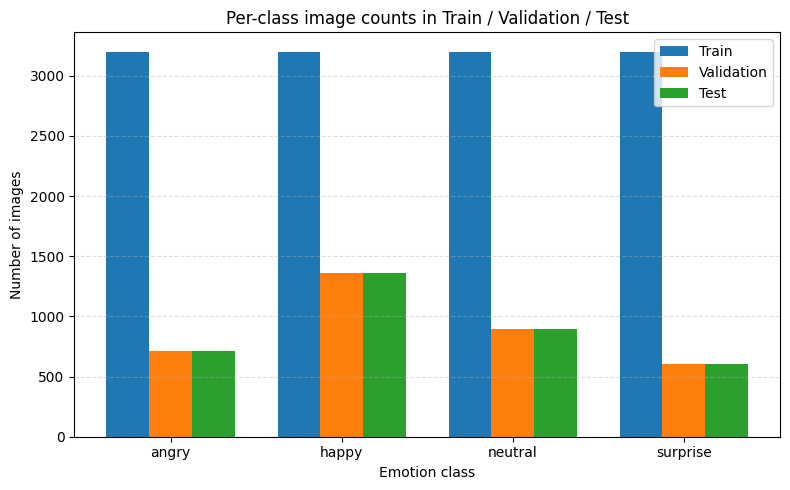

In [110]:
def count_images_in_split(base_dir, classes):
    counts = {}
    for cls in classes:
        cls_path = os.path.join(base_dir, cls)
        if not os.path.exists(cls_path):
            counts[cls] = 0
            continue
        exts = (".jpg", ".jpeg", ".png")
        files = [f for f in os.listdir(cls_path) if f.lower().endswith(exts)]
        counts[cls] = len(files)
    return counts

# Count per split
train_counts = count_images_in_split(train_dir, classes)
val_counts   = count_images_in_split(val_dir, classes)
test_counts  = count_images_in_split(test_dir, classes)

print("Train counts:", train_counts)
print("Val counts:",   val_counts)
print("Test counts:",  test_counts)

# Prepare data for grouped bar chart
train_vals = [train_counts[c] for c in classes]
val_vals   = [val_counts[c]   for c in classes]
test_vals  = [test_counts[c]  for c in classes]

x = np.arange(len(classes))
width = 0.25

plt.figure(figsize=(8, 5))

plt.bar(x - width,     train_vals, width, label="Train")
plt.bar(x,             val_vals,   width, label="Validation")
plt.bar(x + width,     test_vals,  width, label="Test")

plt.xlabel("Emotion class")
plt.ylabel("Number of images")
plt.title("Per-class image counts in Train / Validation / Test")
plt.xticks(x, classes)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [111]:
# =========================
# 🔹 Step 3: Data Preprocessing (No Augmentation)
# =========================
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# সব dataset-এর জন্য শুধু rescaling
datagen = ImageDataGenerator(rescale=1./255)

# =========================
# 🔹 Generators
# =========================
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(96, 96),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(96, 96),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(96, 96),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 12800 images belonging to 4 classes.
Found 3569 images belonging to 4 classes.
Found 3571 images belonging to 4 classes.


In [112]:
from sklearn.utils.class_weight import compute_class_weight
# 🔹 Step 4: Compute Class Weights (optional but helpful)
# =========================
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


In [113]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation
model = Sequential()

num_classes = 4  # angry, happy, neutral, surprise

model = Sequential()

# Block 1
model.add(Conv2D(64, (3,3), padding='same', input_shape=(96,96,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))   # 0.25 -> 0.3

# Block 2
model.add(Conv2D(128, (5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))   # 0.25 -> 0.3

# Block 3 (filters ektu kom)
model.add(Conv2D(256, (3,3), padding='same'))  # 512 -> 256
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.35))

# Block 4
model.add(Conv2D(256, (3,3), padding='same'))  # 512 -> 256
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.35))

# Dense
model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))   # 0.25 -> 0.4

model.add(Dense(128))     # 512 -> 128
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

# Output layer (4 classes)
model.add(Dense(num_classes, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 96, 96, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 96, 96, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 96, 96, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 48, 48, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 256)            │         1,02

 Total params: 3,488,132 (13.31 MB)

 Trainable params: 3,485,956 (13.30 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [114]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
# =========================
# 🔹 Step 6: Compile Model
# =========================
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# =========================
# 🔹 Step 7: Callbacks
# =========================
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [115]:
# =========================
# 🔹 Step 8: Train Model
# =========================
EPOCHS = 40

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # optional
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,  # optional
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights
)

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.3589 - loss: 1.4768 - val_accuracy: 0.3861 - val_loss: 1.3317 - learning_rate: 0.0010
Epoch 2/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.5305 - loss: 1.0811 - val_accuracy: 0.4759 - val_loss: 1.2288 - learning_rate: 0.0010
Epoch 3/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.6211 - loss: 0.9280 - val_accuracy: 0.3739 - val_loss: 1.4092 - learning_rate: 0.0010
Epoch 4/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.6538 - loss: 0.8431 - val_accuracy: 0.6233 - val_loss: 0.8603 - learning_rate: 0.0010
Epoch 5/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.7005 - loss: 0.7651 - val_accuracy: 0.6838 - val_loss: 0.7680 - learning_rate: 0.0010
Epoch 6/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.7125 - loss: 0.7254 - val_accuracy: 0.6830 - val_loss: 0.7927 - learning_rate: 0.0010
Epoch 7/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.7300 - loss: 0.6945 - val

In [116]:
# Training & Validation accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

# Test accuracy
test_loss, test_acc = model.evaluate(test_generator, verbose=0)

print("📊 Model Accuracy Summary:")
print(f"   🔹 Training Accuracy:   {train_acc*100:.2f}%")
print(f"   🔹 Validation Accuracy: {val_acc*100:.2f}%")
print(f"   🔹 Test Accuracy:       {test_acc*100:.2f}%")

📊 Model Accuracy Summary:
   🔹 Training Accuracy:   86.02%
   🔹 Validation Accuracy: 77.84%
   🔹 Test Accuracy:       77.85%


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


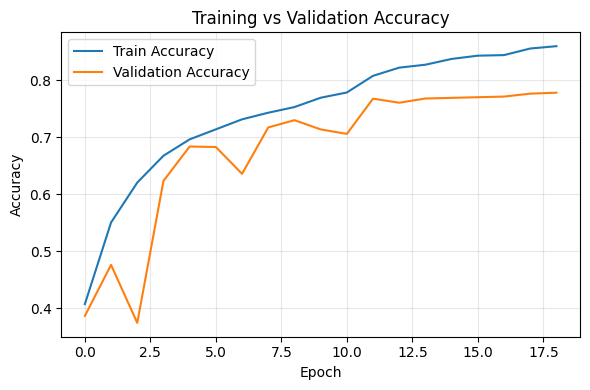

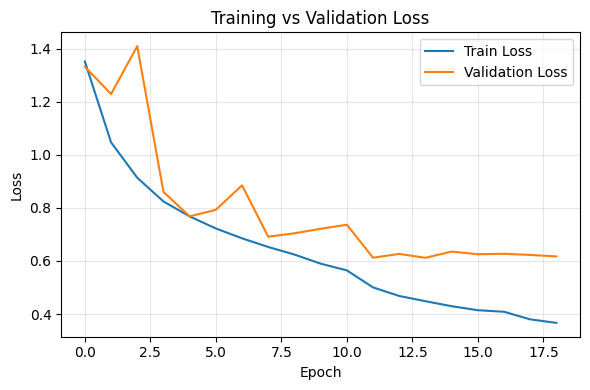

In [117]:
# History keys check korte chaile:
print(history.history.keys())

# 1) Accuracy curve (train vs validation)
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2) Loss curve (train vs validation)
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [118]:
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7358 - loss: 0.6347
Test Loss: 0.5892676711082458
Test Accuracy: 0.7784934043884277


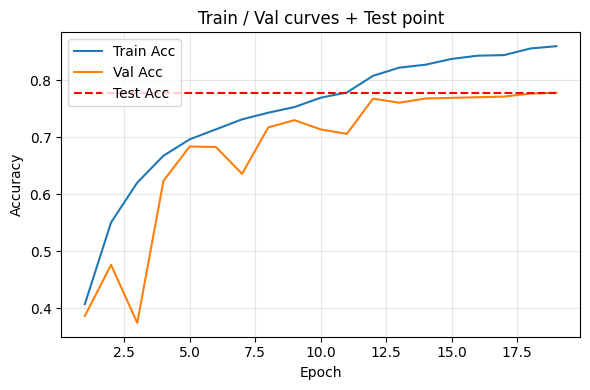

In [119]:
import matplotlib.pyplot as plt

# dhore nilam history, test_acc already ache
epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, history.history['accuracy'], label='Train Acc')
plt.plot(epochs, history.history['val_accuracy'], label='Val Acc')

plt.hlines(test_acc, xmin=1, xmax=len(epochs), colors='red', linestyles='dashed', label='Test Acc')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train / Val curves + Test point')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
Classes: ['angry', 'happy', 'neutral', 'surprise']
Confusion Matrix:
 [[ 456   64  177   16]
 [  70 1169  102   19]
 [ 112   88  678   18]
 [  24   50   51  477]]

Classification Report:
               precision    recall  f1-score   support

       angry       0.69      0.64      0.66       713
       happy       0.85      0.86      0.86      1360
     neutral       0.67      0.76      0.71       896
    surprise       0.90      0.79      0.84       602

    accuracy                           0.78      3571
   macro avg       0.78      0.76      0.77      3571
weighted avg       0.78      0.78      0.78      3571



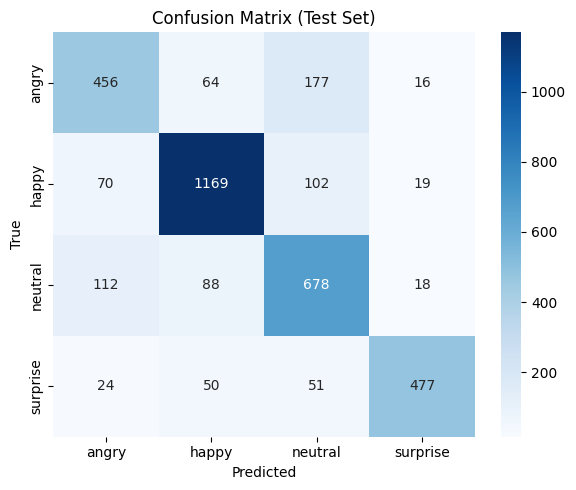

In [120]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure no shuffling
test_generator.shuffle = False
test_generator.reset()

# Predict probabilities
y_prob = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_prob, axis=1)           # predicted class index
y_true = test_generator.classes              # true labels

class_names = list(test_generator.class_indices.keys())
print("Classes:", class_names)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

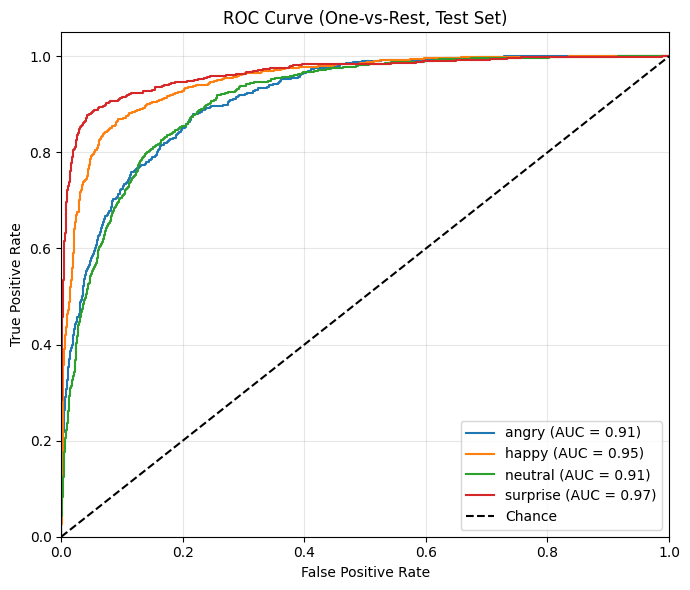

In [121]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# One-hot true labels
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=range(n_classes))  # shape: (N, n_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(7,6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest, Test Set)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# **Mobile Net V1**

In [122]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ===============================
# 🔹 Transforms
# ===============================
train_transform = transforms.Compose([
    transforms.Resize((48,48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((48,48)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

Device: cuda


In [123]:
# ===============================
# 🔹 Datasets & Dataloaders
# ===============================
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_dir,   transform=test_transform)
test_dataset  = datasets.ImageFolder(test_dir,  transform=test_transform)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2)

classes = train_dataset.classes
num_classes = len(classes)
print("Classes:", classes)
print("Train size:", len(train_dataset), "Val size:", len(val_dataset), "Test size:", len(test_dataset))

# ===============================
# 🔹 Class Weights (for imbalance)
# ===============================
y_train = np.array(train_dataset.targets)

class_weights_np = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
print("Class weights (numpy):", class_weights_np)

class_weights = torch.tensor(class_weights_np, dtype=torch.float32).to(device)

# ===============================
# 🔹 MobileNetV1 Model
# ===============================
class MobileNetV1(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV1, self).__init__()

        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
            )

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
            )

        self.model = nn.Sequential(
            conv_bn(3,32,2),
            conv_dw(32,64,1),
            conv_dw(64,128,2),
            conv_dw(128,128,1),
            conv_dw(128,256,2),
            conv_dw(256,256,1),
            conv_dw(256,512,2),
            conv_dw(512,512,1),
            conv_dw(512,512,1),
            conv_dw(512,512,1),
            conv_dw(512,512,1),
            conv_dw(512,512,1),
            conv_dw(512,1024,2),
            conv_dw(1024,1024,1),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Dropout(0.5)
        )
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = MobileNetV1(num_classes=num_classes).to(device)
print("Model created on device:", device)

# ===============================
# 🔹 Loss & Optimizer
# ===============================
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ===============================
# 🔹 Training Loop (with early stopping)
# ===============================
num_epochs = 30
best_val_acc = 0.0
patience = 6
trigger_times = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    # ----- Training -----
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # ----- Validation -----
    model.eval()
    val_loss_sum, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss_sum += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss_sum / total
    val_acc = correct / total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # ----- Early stopping -----
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        trigger_times = 0
        torch.save(model.state_dict(), "best_mobilenetv1.pth")
        print("Saved best model!")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered")
            break

Classes: ['angry', 'happy', 'neutral', 'surprise']
Train size: 12800 Val size: 3569 Test size: 3571
Class weights (numpy): [1. 1. 1. 1.]
Model created on device: cuda
Epoch [1/30] | Train Loss: 1.4166, Train Acc: 0.2856 | Val Loss: 1.3248, Val Acc: 0.3743
Saved best model!
Epoch [2/30] | Train Loss: 1.3645, Train Acc: 0.3340 | Val Loss: 1.2771, Val Acc: 0.4021
Saved best model!
Epoch [3/30] | Train Loss: 1.3000, Train Acc: 0.3927 | Val Loss: 1.2652, Val Acc: 0.4505
Saved best model!
Epoch [4/30] | Train Loss: 1.2183, Train Acc: 0.4580 | Val Loss: 1.1461, Val Acc: 0.5206
Saved best model!
Epoch [5/30] | Train Loss: 1.1669, Train Acc: 0.4873 | Val Loss: 1.0941, Val Acc: 0.5455
Saved best model!
Epoch [6/30] | Train Loss: 1.1109, Train Acc: 0.5245 | Val Loss: 1.0719, Val Acc: 0.5545
Saved best model!
Epoch [7/30] | Train Loss: 1.0654, Train Acc: 0.5433 | Val Loss: 0.9836, Val Acc: 0.5859
Saved best model!
Epoch [8/30] | Train Loss: 1.0231, Train Acc: 0.5701 | Val Loss: 0.9574, Val Acc: 0.

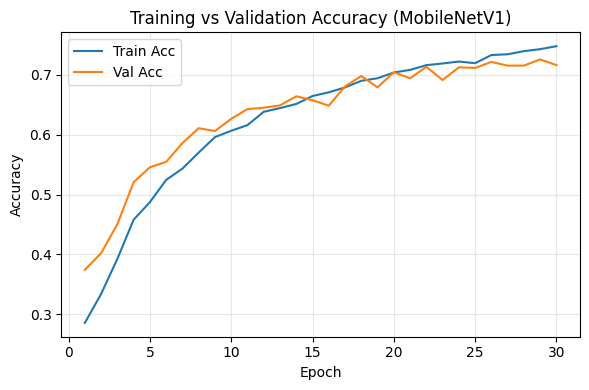

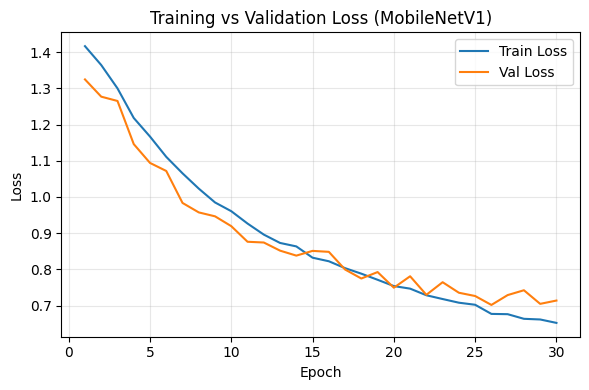

In [124]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(train_losses) + 1)

# Accuracy curve
plt.figure(figsize=(6,4))
plt.plot(epochs_range, train_accs, label="Train Acc")
plt.plot(epochs_range, val_accs,   label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy (MobileNetV1)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Loss curve
plt.figure(figsize=(6,4))
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (MobileNetV1)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Test Accuracy: 77.85%

Test Accuracy: 73.45%


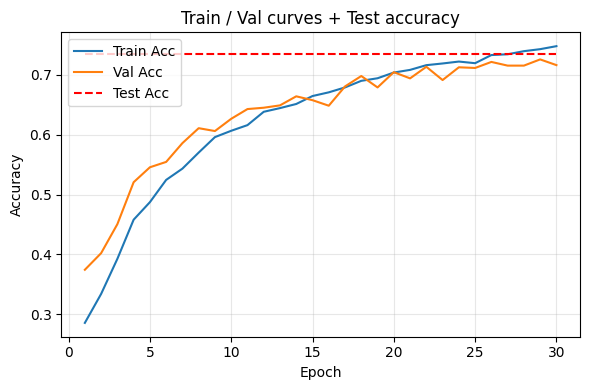

In [125]:
# Test accuracy already ber korechho:
# test_acc = np.mean(all_labels == all_preds)

print(f"Test Accuracy: {test_acc*100:.2f}%")

model.load_state_dict(torch.load("best_mobilenetv1.pth"))
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

test_acc = np.mean(all_labels == all_preds)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

import matplotlib.pyplot as plt

epochs_range = range(1, len(train_accs) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs_range, train_accs, label="Train Acc")
plt.plot(epochs_range, val_accs,   label="Val Acc")

# Test accuracy as horizontal line
plt.hlines(test_acc, xmin=1, xmax=len(epochs_range),
           colors='red', linestyles='dashed', label='Test Acc')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train / Val curves + Test accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Confusion Matrix:
 [[ 394   90  181   48]
 [  70 1105  111   74]
 [ 109  111  620   56]
 [  31   28   39  504]]

Classification Report:
               precision    recall  f1-score   support

       angry       0.65      0.55      0.60       713
       happy       0.83      0.81      0.82      1360
     neutral       0.65      0.69      0.67       896
    surprise       0.74      0.84      0.79       602

    accuracy                           0.73      3571
   macro avg       0.72      0.72      0.72      3571
weighted avg       0.73      0.73      0.73      3571



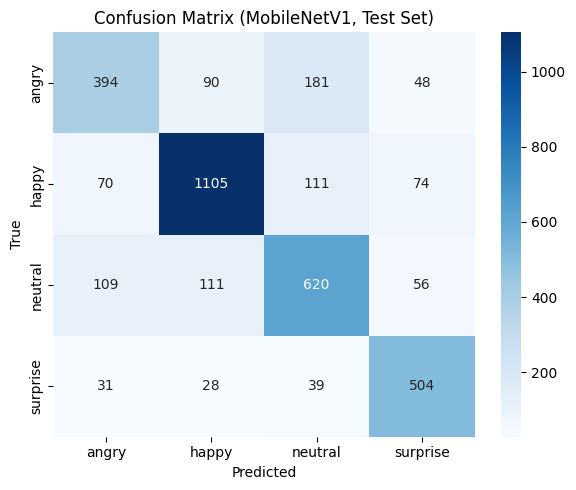

In [126]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# all_labels, all_preds already ache test loop theke
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

class_names = classes   # train_dataset.classes theke asche

print("\nClassification Report:\n",
      classification_report(all_labels, all_preds, target_names=class_names))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (MobileNetV1, Test Set)")
plt.tight_layout()
plt.show()

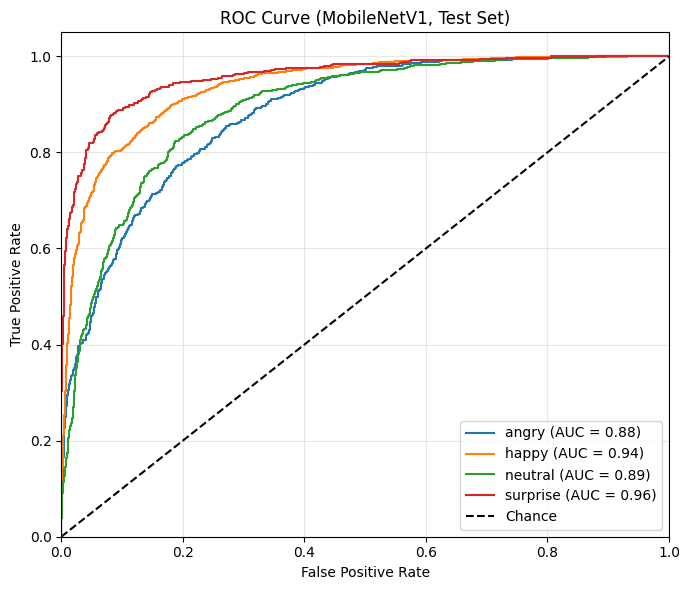

In [127]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

model.load_state_dict(torch.load("best_mobilenetv1.pth"))
model.eval()

all_probs, all_labels = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)                  # logits
        probs = torch.softmax(outputs, dim=1)  # convert to probabilities

        all_probs.append(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_probs = np.concatenate(all_probs, axis=0)   # shape: (N, num_classes)
all_labels = np.array(all_labels)
class_names = classes
n_classes = len(class_names)


# One-hot encode true labels
y_true_bin = label_binarize(all_labels, classes=range(n_classes))  # shape: (N, n_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(7,6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],
             label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (MobileNetV1, Test Set)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# **ResNet-50**

In [167]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import ResNet50_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(train_dataset.classes)

class ResNetFER(nn.Module):
    def __init__(self, num_classes):
        super(ResNetFER, self).__init__()
        # Pretrained ResNet50
        self.backbone = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        
        # Last FC replace
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)

        # Optional: freeze কিছু shallow layer (conv1 + layer1)
        for name, param in self.backbone.named_parameters():
            if name.startswith("layer3") or name.startswith("layer4") or name.startswith("fc"):
                param.requires_grad = True
            else:
                param.requires_grad = False

    def forward(self, x):
        return self.backbone(x)

model = ResNetFER(num_classes=num_classes).to(device)
print(model)


ResNetFER(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [170]:
# class_weights already compute korechish
criterion = nn.CrossEntropyLoss(weight=class_weights)

# আলাদা LR for backbone এবং FC
backbone_params = []
fc_params = []
for name, param in model.named_parameters():
    if not param.requires_grad:
        continue
    if "fc" in name or "layer4" in name:
        fc_params.append(param)      # higher LR
    else:
        backbone_params.append(param)  # lower LR

optimizer = optim.Adam([
    {"params": backbone_params, "lr": 1e-4},
    {"params": fc_params, "lr": 1e-3},
], weight_decay=1e-4)

# LR scheduler (optional but recommended)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3, verbose=True
)

In [171]:
# ============================================================
# HISTORY LISTS FOR PLOTTING
# ============================================================
train_losses_list = []
val_losses_list = []
train_acc_list = []
val_acc_list = []

# ============================================================
# TRAINING LOOP
# ============================================================
num_epochs = 30
best_val_acc = 0.0
patience = 6
trigger_times = 0

for epoch in range(num_epochs):
    # ---------- Train ----------
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # ---------- Validation ----------
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= total
    val_acc = correct / total

    # Save history
    train_losses_list.append(train_loss)
    val_losses_list.append(val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    scheduler.step(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"| Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} "
          f"| Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
   # ---------- Early stopping ----------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        trigger_times = 0
        torch.save(model.state_dict(), "best_resnet50_fer.pth")
        print("Saved best ResNet50 FER model!")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered")
            break


Epoch [1/30] | Train Acc: 0.5625 | Val Acc: 0.6621 | Train Loss: 1.0746 | Val Loss: 1.0963
Saved best ResNet50 FER model!
Epoch [2/30] | Train Acc: 0.6719 | Val Acc: 0.7187 | Train Loss: 0.8365 | Val Loss: 0.7388
Saved best ResNet50 FER model!
Epoch [3/30] | Train Acc: 0.7016 | Val Acc: 0.7277 | Train Loss: 0.7504 | Val Loss: 0.7004
Saved best ResNet50 FER model!
Epoch [4/30] | Train Acc: 0.7264 | Val Acc: 0.7361 | Train Loss: 0.7085 | Val Loss: 0.6994
Saved best ResNet50 FER model!
Epoch [5/30] | Train Acc: 0.7409 | Val Acc: 0.7445 | Train Loss: 0.6592 | Val Loss: 0.6852
Saved best ResNet50 FER model!
Epoch [6/30] | Train Acc: 0.7570 | Val Acc: 0.7324 | Train Loss: 0.6276 | Val Loss: 0.6843
Epoch [7/30] | Train Acc: 0.7709 | Val Acc: 0.7439 | Train Loss: 0.6035 | Val Loss: 0.6788
Epoch [8/30] | Train Acc: 0.7848 | Val Acc: 0.7593 | Train Loss: 0.5668 | Val Loss: 0.6812
Saved best ResNet50 FER model!
Epoch [9/30] | Train Acc: 0.7880 | Val Acc: 0.7534 | Train Loss: 0.5506 | Val Loss: 0.

In [172]:
model.load_state_dict(torch.load("best_resnet50_fer.pth"))
model.eval()

correct, total = 0, 0

with torch.no_grad():
    for imgs, labels in test_loader:  # use your test_loader
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.7709


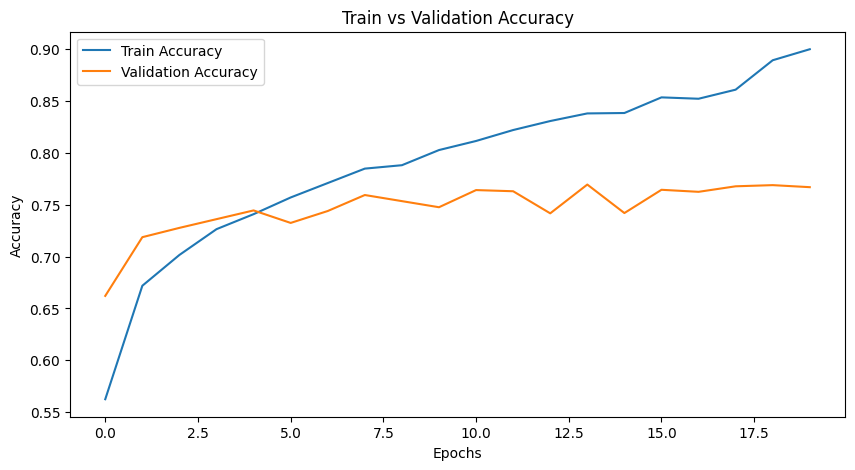

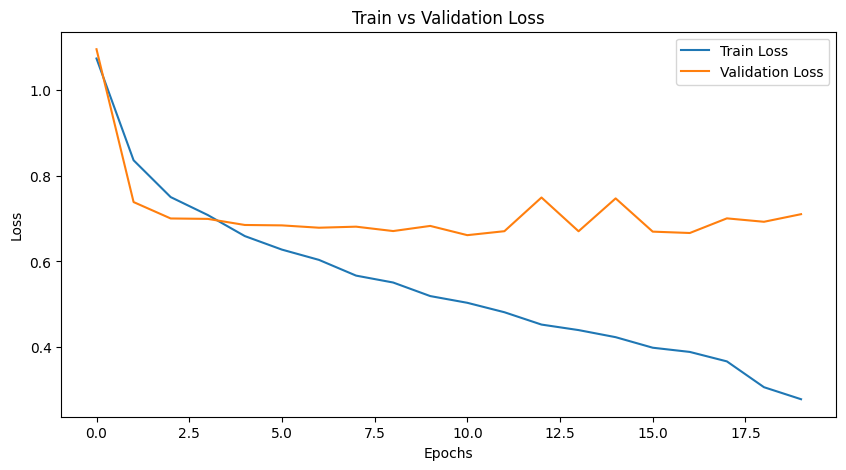

In [173]:
# ============================================================
# PLOTS
# ============================================================

# ---- Accuracy ----
plt.figure(figsize=(10,5))
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.show()

# ---- Loss ----
plt.figure(figsize=(10,5))
plt.plot(train_losses_list, label="Train Loss")
plt.plot(val_losses_list, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()


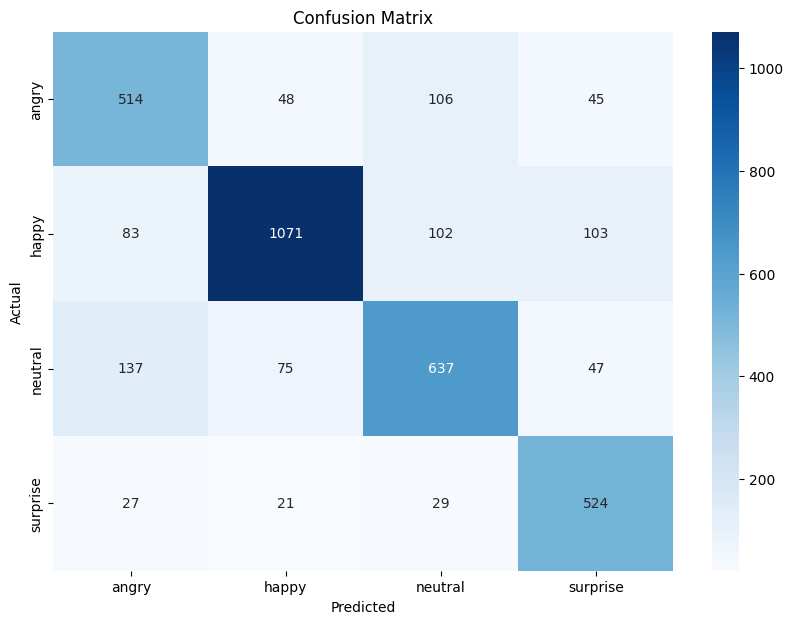

In [174]:
# ============================================================
# CONFUSION MATRIX
# ============================================================
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

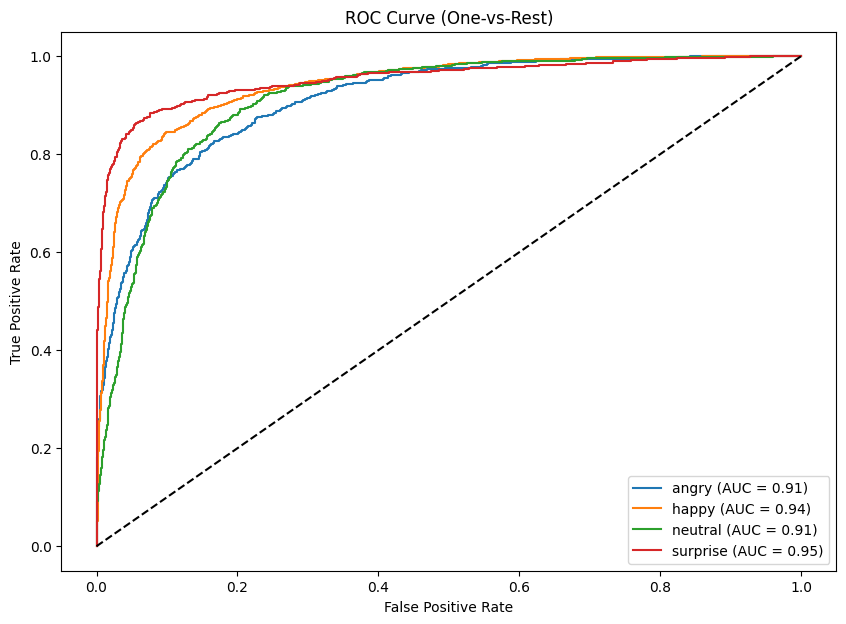

In [175]:
# ============================================================
# ROC CURVE (MULTICLASS)
# ============================================================
num_classes = len(train_dataset.classes)

# Binarize labels
y_true = label_binarize(all_labels, classes=list(range(num_classes)))

# Softmax probabilities
model.eval()
y_prob = []

with torch.no_grad():
    for imgs, _ in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)
        y_prob.extend(probs.cpu().numpy())

y_prob = np.array(y_prob)

plt.figure(figsize=(10,7))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{train_dataset.classes[i]} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend()
plt.show()


# **Hybridge Model**

In [ ]:
# ===============================
# 🔹 Datasets & Dataloaders
# ===============================
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_dir,   transform=test_transform)
test_dataset  = datasets.ImageFolder(test_dir,  transform=test_transform)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2)

classes = train_dataset.classes
num_classes = len(classes)
print("Classes:", classes)
print("Train size:", len(train_dataset), "Val size:", len(val_dataset), "Test size:", len(test_dataset))

# ===============================
# 🔹 Class Weights (for imbalance)
# ===============================
y_train = np.array(train_dataset.targets)

class_weights_np = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
print("Class weights (numpy):", class_weights_np)

class_weights = torch.tensor(class_weights_np, dtype=torch.float32).to(device)

In [160]:
# ===============================
# 🔹 Class weights
# ===============================
y_train = np.array(train_dataset.targets)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class Weights:", class_weights)

# ===============================
# 🔹 Hybrid Model
# ===============================
class HybridFER(nn.Module):
    def __init__(self, num_classes):
        super(HybridFER, self).__init__()

        # ---- CNN branch ----
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(3,32,3,1,1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,1,1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,1,1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )

        # ---- MobileNetV1 branch ----
        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
            )
        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
            )
        self.mobilenet_branch = nn.Sequential(
            conv_bn(3,32,2),
            conv_dw(32,64,1),
            conv_dw(64,128,2),
            conv_dw(128,128,1),
            conv_dw(128,256,2),
            conv_dw(256,256,1),
            conv_dw(256,512,2),
            conv_dw(512,512,1),
            conv_dw(512,512,1),
            nn.AdaptiveAvgPool2d(1)
        )

        # ---- Transfer learning branch (ResNet50) ----
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]  # remove final fc
        self.resnet_branch = nn.Sequential(*modules)
        for param in self.resnet_branch.parameters():
            param.requires_grad = False  # freeze ResNet50

        # ---- Fully connected after concatenation ----
        self.fc = nn.Sequential(
            nn.Linear(128 + 512 + 2048, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        f1 = self.cnn_branch(x).view(x.size(0), -1)
        f2 = self.mobilenet_branch(x).view(x.size(0), -1)
        f3 = self.resnet_branch(x).view(x.size(0), -1)
        out = torch.cat([f1,f2,f3], dim=1)
        out = self.fc(out)
        return out

model = HybridFER(num_classes=len(train_dataset.classes)).to(device)
print("Hybrid Model created.")


Class Weights: tensor([1., 1., 1., 1.], device='cuda:0')


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Hybrid Model created.


In [162]:
# ===============================
# 🔹 Loss & Optimizer
# ===============================
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# ===============================
# 🔹 Training Loop
# ===============================
num_epochs = 30
best_val_acc = 0.0
patience = 6
trigger_times = 0

# Store metrics
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_loss = running_loss / total
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss_sum, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss_sum += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_loss = val_loss_sum / total
    val_acc = correct / total

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        trigger_times = 0
        torch.save(model.state_dict(), "best_hybrid_fer.pth")
        print("Saved best hybrid model!")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered")
            break


Epoch [1/30] | Train Acc: 0.3777 | Val Acc: 0.4584 | Train Loss: 1.3113 | Val Loss: 1.2455
Saved best hybrid model!
Epoch [2/30] | Train Acc: 0.4505 | Val Acc: 0.5091 | Train Loss: 1.2193 | Val Loss: 1.1132
Saved best hybrid model!
Epoch [3/30] | Train Acc: 0.4985 | Val Acc: 0.5394 | Train Loss: 1.1403 | Val Loss: 1.0957
Saved best hybrid model!
Epoch [4/30] | Train Acc: 0.5348 | Val Acc: 0.5637 | Train Loss: 1.0837 | Val Loss: 1.0337
Saved best hybrid model!
Epoch [5/30] | Train Acc: 0.5521 | Val Acc: 0.6016 | Train Loss: 1.0476 | Val Loss: 0.9588
Saved best hybrid model!
Epoch [6/30] | Train Acc: 0.5763 | Val Acc: 0.6195 | Train Loss: 1.0128 | Val Loss: 0.9336
Saved best hybrid model!
Epoch [7/30] | Train Acc: 0.5899 | Val Acc: 0.6125 | Train Loss: 0.9798 | Val Loss: 0.9255
Epoch [8/30] | Train Acc: 0.6031 | Val Acc: 0.6383 | Train Loss: 0.9537 | Val Loss: 0.8988
Saved best hybrid model!
Epoch [9/30] | Train Acc: 0.6214 | Val Acc: 0.6282 | Train Loss: 0.9231 | Val Loss: 0.9107
Epoch 

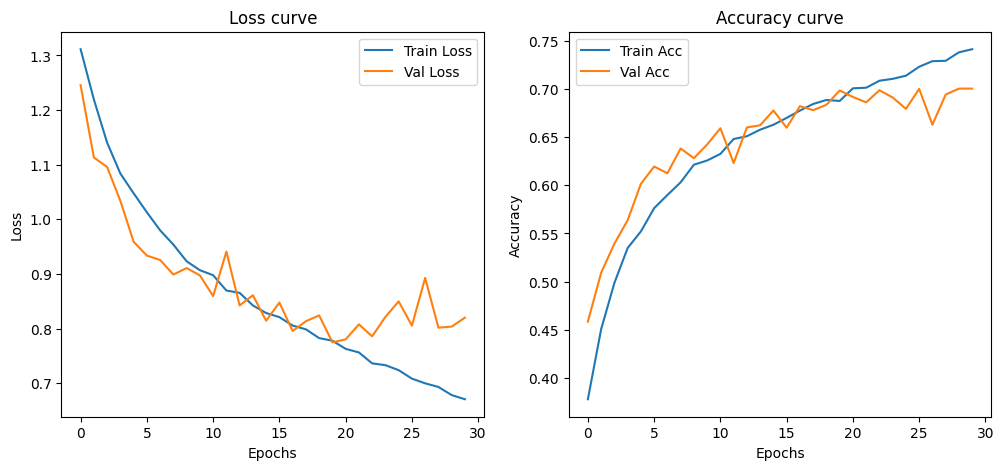

In [163]:
# ===============================
# 🔹 Plot train/val curves
# ===============================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

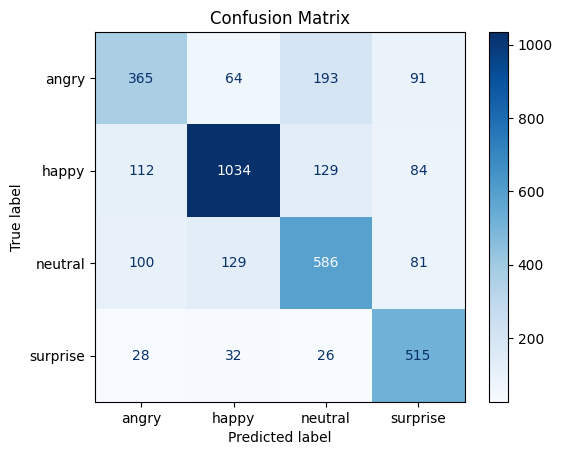

In [164]:
# ===============================
# 🔹 Confusion Matrix
# ===============================
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = outputs.max(1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

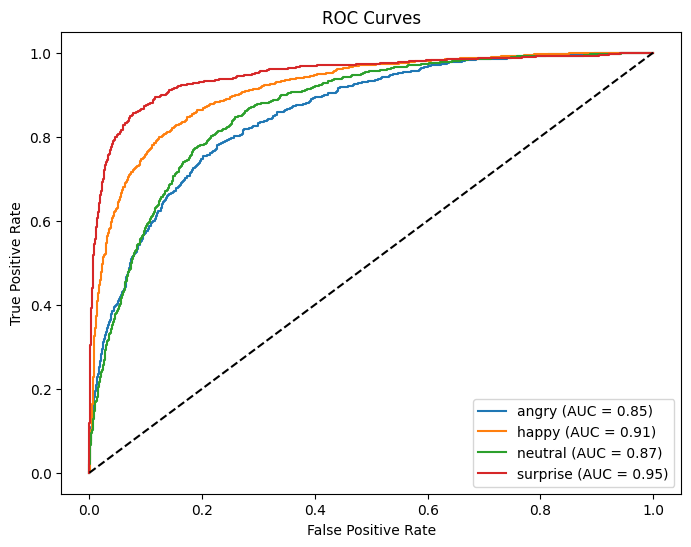

In [165]:
# ===============================
# 🔹 Multi-class ROC Curve
# ===============================
n_classes = len(train_dataset.classes)
all_labels_bin = label_binarize(all_labels, classes=np.arange(n_classes))
all_outputs = []

with torch.no_grad():
    for imgs, _ in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        all_outputs.append(F.softmax(outputs, dim=1).cpu())

all_outputs = torch.cat(all_outputs).numpy()

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:,i], all_outputs[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
for i, class_name in enumerate(train_dataset.classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_name} (AUC = {roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()